In [1]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from ultralytics import YOLO
from scipy.spatial import distance
from tqdm import tqdm
from itertools import combinations
import os

# --- 1. Configurações de Caminhos ---
MODEL_PATH = 'runs/pose/yolov8_cattle_pose/weights/best.pt'
DATASET_PATH = '../data/raw/dataset_classificação'
OUTPUT_DIR = '../data/processed'
OUTPUT_CSV = f'{OUTPUT_DIR}/biometria_final_pos.csv'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Carregar modelo treinado
model = YOLO(MODEL_PATH)

# --- 2. Funções Utilitárias de Geometria ---

def calcular_angulo_3p(p1, p2, p3):
    """Calcula o ângulo interno no ponto p2 (Invariante à rotação)"""
    ba = p1 - p2
    bc = p3 - p2
    norm_ba = np.linalg.norm(ba)
    norm_bc = np.linalg.norm(bc)
    if norm_ba == 0 or norm_bc == 0: return 0
    cosine_angle = np.dot(ba, bc) / (norm_ba * norm_bc + 1e-6)
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

def extrair_geometria_completa(kp, ref_dist):
    """Gera 28 distâncias normalizadas + ângulos + áreas"""
    geo = {}
    
    # A. Todas as 28 distâncias possíveis (C(8,2))
    # Fornece a morfologia completa do animal para o XGBoost
    for i, j in combinations(range(8), 2):
        geo[f'geo_dist_{i}_{j}'] = distance.euclidean(kp[i], kp[j]) / ref_dist
        
    # B. Ângulos Estruturais
    geo['geo_angle_spine'] = calcular_angulo_3p(kp[0], kp[1], kp[5]) # Withers-Back-Tail
    geo['geo_angle_rump'] = calcular_angulo_3p(kp[2], kp[5], kp[3])  # Hook-Tail-Hook
    geo['geo_angle_pelvis'] = calcular_angulo_3p(kp[6], kp[5], kp[7]) # Pin-Tail-Pin
    
    # C. Área do Quadril (Normalizada)
    poly_hip = np.array([kp[2], kp[6], kp[7], kp[3]], dtype=np.int32)
    geo['geo_area_hip'] = cv2.contourArea(poly_hip) / (ref_dist**2)
    
    return geo

# --- 3. Funções de Textura e Cor (Filtro de Reflexos) ---

def aplicar_clahe(patch):
    """Equalização para realçar textura sob reflexos"""
    lab = cv2.cvtColor(patch, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def extrair_sift_binarizado(patch, prefixo, threshold_val=220):
    """Sua ideia: SIFT apenas em tons de 'branco puro' para isolar manchas"""
    gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    
    # Binarização agressiva (isolar manchas brancas de reflexos cinzas)
    _, mask = cv2.threshold(gray, threshold_val, 255, cv2.THRESH_BINARY)
    
    sift = cv2.SIFT_create()
    kp_sift = sift.detect(mask, None)
    
    return {f'img_{prefixo}_sift_pure_white': len(kp_sift)}

def extrair_estatisticas_cor(patch, prefixo):
    """Média e STD por canal na ROI"""
    stats = {}
    for i, color in enumerate(['b', 'g', 'r']):
        stats[f'img_{prefixo}_mean_{color}'] = np.mean(patch[:,:,i])
        stats[f'img_{prefixo}_std_{color}'] = np.std(patch[:,:,i])
    return stats

# --- 4. Loop Principal de Processamento ---

data_rows = []
pastas_animais = sorted([p for p in Path(DATASET_PATH).iterdir() if p.is_dir()])

for pasta in pastas_animais:
    print(f"📂 Processando ID: {pasta.name}")
    imagens = list(pasta.glob('*.jpg'))
    
    for img_p in tqdm(imagens):
        results = model(img_p, verbose=False)[0]
        if not results.keypoints or len(results.keypoints.xy[0]) < 8:
            continue
            
        kp = results.keypoints.xy[0].cpu().numpy()
        img_raw = cv2.imread(str(img_p))
        
        # Distância de Referência (Withers [0] até Tail Head [5])
        ref_dist = distance.euclidean(kp[0], kp[5])
        if ref_dist < 1.0: continue

        # Iniciar dicionário da linha (amostra)
        feat = {'cow_id': pasta.name, 'file_name': img_p.name}

        # --- A. Extração Geométrica Expandida ---
        feat.update(extrair_geometria_completa(kp, ref_dist))

        # --- B. Extração de ROIs Locais ---
        # Foco no Lombo (1), Quadril (4) e Base da Cauda (5)
        for idx_pt, nome_roi in zip([1, 4, 5], ['back', 'hip', 'tail']):
            px, py = int(kp[idx_pt][0]), int(kp[idx_pt][1])
            # Patch de 50x50 para capturar mais contexto de manchas
            patch = img_raw[max(0, py-25):py+25, max(0, px-25):px+25]
            
            if patch.size > 0:
                # 1. SIFT Binarizado (Sua ideia de filtrar reflexos)
                feat.update(extrair_sift_binarizado(patch, nome_roi))
                
                # 2. Cor e Textura (com CLAHE para mitigar iluminação)
                patch_clean = aplicar_clahe(patch)
                feat.update(extrair_estatisticas_cor(patch_clean, nome_roi))
        
        data_rows.append(feat)

# --- 5. Salvamento ---
df_final = pd.DataFrame(data_rows)
df_final.to_csv(OUTPUT_CSV, index=False)

print(f"\n✅ Dataset Biométrico Finalizado!")
print(f"   - Total de imagens: {len(df_final)}")
print(f"   - Total de Features: {df_final.shape[1] - 2}")
print(f"   - Salvo em: {OUTPUT_CSV}")

📂 Processando ID: 1106


  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/paulo/Code/cattle-identification/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:1007: UserWarning: Can't initialize NVML
  raw_cnt = _raw_device_count_nvml()
100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.14it/s]


📂 Processando ID: 1122


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 30.04it/s]


📂 Processando ID: 1221


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 21.94it/s]


📂 Processando ID: 1287


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 23.58it/s]


📂 Processando ID: 1288


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.13it/s]


📂 Processando ID: 1294


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 28.27it/s]


📂 Processando ID: 1321


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 23.36it/s]


📂 Processando ID: 1323


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 23.67it/s]


📂 Processando ID: 1325


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 21.38it/s]


📂 Processando ID: 1328


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 25.70it/s]


📂 Processando ID: 1351


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 28.26it/s]


📂 Processando ID: 1356


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 21.34it/s]


📂 Processando ID: 1362


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.72it/s]


📂 Processando ID: 1377


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 25.09it/s]


📂 Processando ID: 1386


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 26.47it/s]


📂 Processando ID: 1391


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 25.99it/s]


📂 Processando ID: 1397


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 25.62it/s]


📂 Processando ID: 1399


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 22.74it/s]


📂 Processando ID: 1439


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 23.69it/s]


📂 Processando ID: 1440


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.17it/s]


📂 Processando ID: 1446


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 21.96it/s]


📂 Processando ID: 1456


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 16.67it/s]


📂 Processando ID: 1463


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 20.84it/s]


📂 Processando ID: 1464


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 20.38it/s]


📂 Processando ID: 1473


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 19.57it/s]


📂 Processando ID: 1491


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.53it/s]


📂 Processando ID: 1495


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 26.65it/s]


📂 Processando ID: 1531


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 19.62it/s]


📂 Processando ID: 1539


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 29.79it/s]


📂 Processando ID: 1562


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 20.09it/s]



✅ Dataset Biométrico Finalizado!
   - Total de imagens: 1500
   - Total de Features: 53
   - Salvo em: ../data/processed/biometria_final_pos.csv


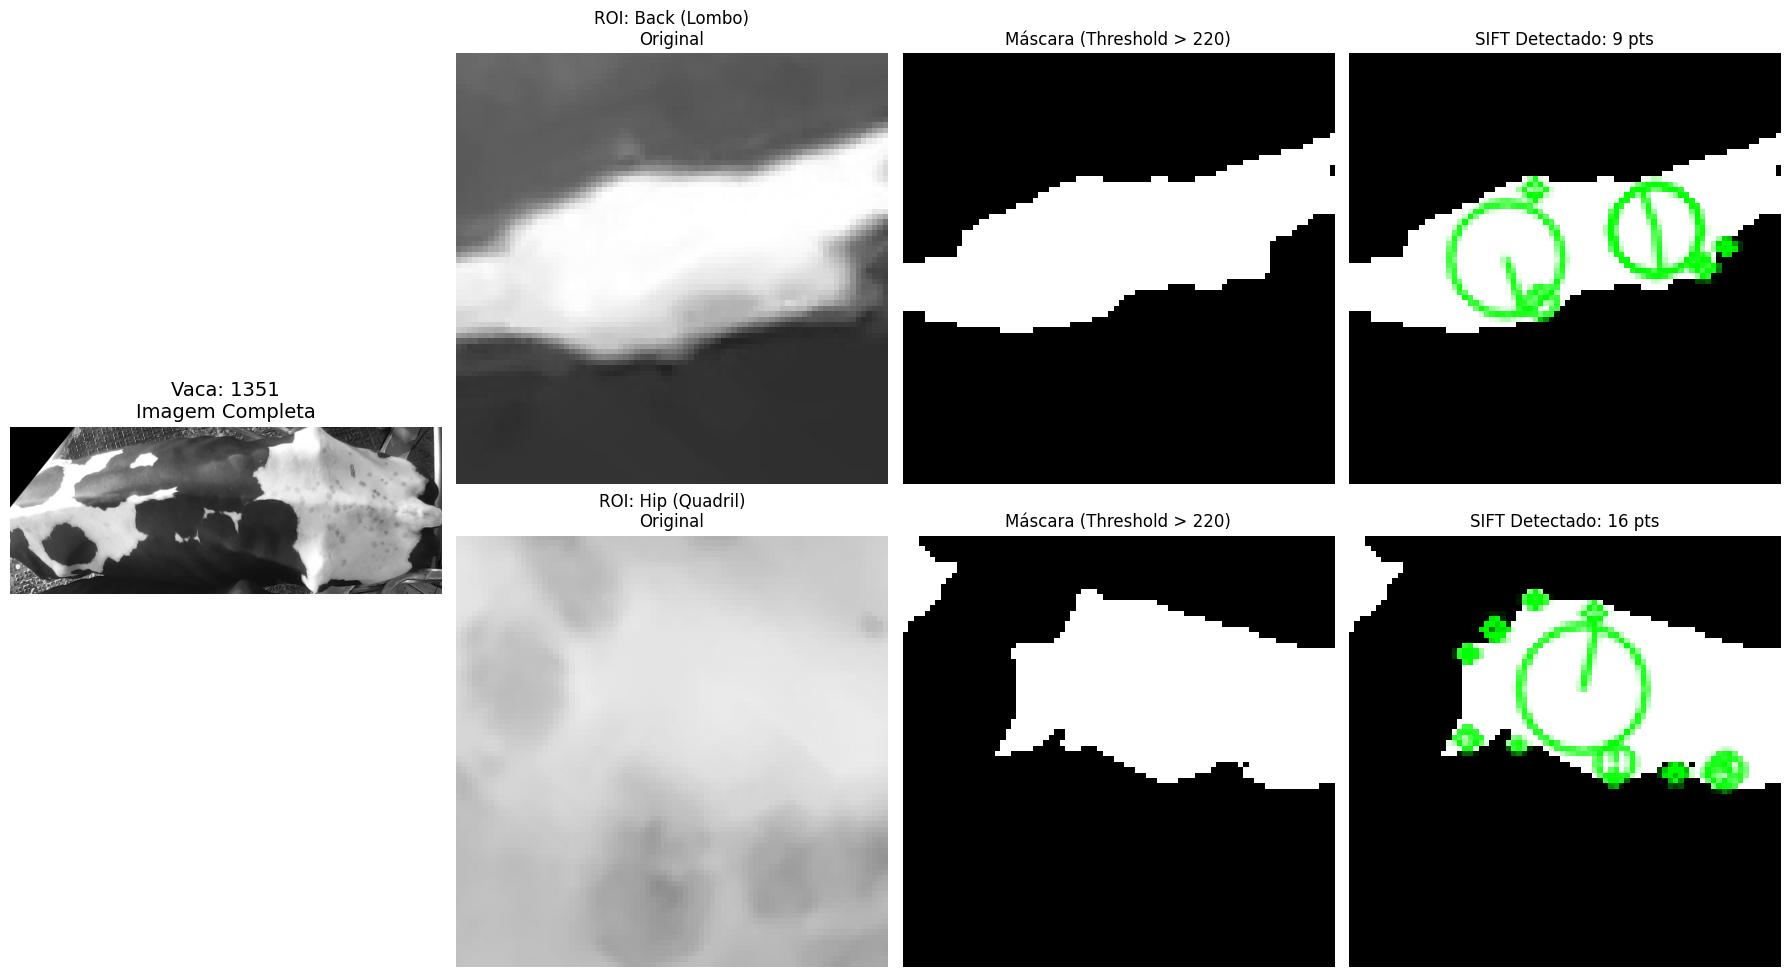

In [14]:
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

def poc_sift_binarizado(cow_id, threshold_val=220):
    # 1. Buscar imagens do animal
    pasta_animal = Path(DATASET_PATH) / cow_id
    imagens = list(pasta_animal.glob('*.jpg'))
    if not imagens: 
        print(f"Nenhuma imagem encontrada para o ID {cow_id}")
        return
    
    img_p = random.choice(imagens)
    
    # 2. Processar com YOLO-pose
    results = model(img_p, verbose=False)[0]
    if not results.keypoints: return
    
    kp = results.keypoints.xy[0].cpu().numpy()
    img_raw = cv2.imread(str(img_p))
    sift = cv2.SIFT_create()
    
    # Definir as ROIs para visualização
    rois = [(1, 'Back (Lombo)'), (4, 'Hip (Quadril)')]
    
    # Criar a figura: 1 linha para a imagem original + 2 linhas (uma por ROI)
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 4)
    
    # Plot da Imagem Original com os Keypoints
    ax_main = fig.add_subplot(gs[:, 0])
    img_viz = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    ax_main.imshow(img_viz)
    ax_main.set_title(f"Vaca: {cow_id}\nImagem Completa", fontsize=14)
    ax_main.axis('off')

    for row, (idx_pt, nome) in enumerate(rois):
        px, py = int(kp[idx_pt][0]), int(kp[idx_pt][1])
        patch = img_raw[max(0, py-40):py+40, max(0, px-40):px+40]
        
        if patch.size > 0:
            # A. Patch Original (RGB)
            ax_orig = fig.add_subplot(gs[row, 1])
            ax_orig.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
            ax_orig.set_title(f"ROI: {nome}\nOriginal")
            ax_orig.axis('off')
            
            # B. Máscara Binarizada (Sua ideia: Limiar > 220)
            gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(gray, threshold_val, 255, cv2.THRESH_BINARY)
            ax_mask = fig.add_subplot(gs[row, 2])
            ax_mask.imshow(mask, cmap='gray')
            ax_mask.set_title(f"Máscara (Threshold > {threshold_val})")
            ax_mask.axis('off')
            
            # C. SIFT sobre a Máscara
            kp_sift = sift.detect(mask, None)
            patch_sift = cv2.drawKeypoints(
                mask, kp_sift, None, 
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
                color=(0, 255, 0)
            )
            ax_sift = fig.add_subplot(gs[row, 3])
            ax_sift.imshow(patch_sift)
            ax_sift.set_title(f"SIFT Detectado: {len(kp_sift)} pts")
            ax_sift.axis('off')

    plt.tight_layout()
    plt.show()

# --- TESTE AQUI ---
# Dica: Teste com o ID de uma vaca que você sabe que tem reflexos ou manchas
poc_sift_binarizado(cow_id='1351', threshold_val=220)